In [4]:
import sys, os
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

df=pd.read_csv('fer2013.csv')

# print(df.info())
# print(df["Usage"].value_counts())

# print(df.head())
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")


num_features = 64
num_labels = 7
batch_size = 64
epochs = 30
width, height = 48, 48


X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# print(f"shape:{X_train.shape}")
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

# model.summary()

#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

#Training the model
model_info = model.fit(X_train, train_y,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=(X_test, test_y),
             shuffle=True)


#Saving the  model to  use it later on
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")



Epoch 1/30
449/449 [==============================] - 581s 1s/step - loss: 1.7161 - accuracy: 0.2996 - val_loss: 1.6142 - val_accuracy: 0.3603
Epoch 2/30
449/449 [==============================] - 540s 1s/step - loss: 1.4954 - accuracy: 0.4121 - val_loss: 1.4427 - val_accuracy: 0.4500
Epoch 3/30
449/449 [==============================] - 539s 1s/step - loss: 1.3944 - accuracy: 0.4616 - val_loss: 1.3410 - val_accuracy: 0.4837
Epoch 4/30
449/449 [==============================] - 576s 1s/step - loss: 1.3302 - accuracy: 0.4886 - val_loss: 1.2682 - val_accuracy: 0.5149
Epoch 5/30
449/449 [==============================] - 633s 1s/step - loss: 1.2837 - accuracy: 0.5087 - val_loss: 1.2510 - val_accuracy: 0.5135
Epoch 6/30
449/449 [==============================] - 680s 2s/step - loss: 1.2484 - accuracy: 0.5195 - val_loss: 1.2116 - val_accuracy: 0.5411
Epoch 7/30
449/449 [==============================] - 646s 1s/step - loss: 1.2164 - accuracy: 0.5302 - val_loss: 1.2217 - val_accuracy: 0.5258

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


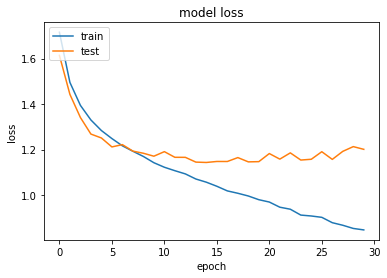

In [5]:
print(model_info.history.keys())

import matplotlib.pyplot as plt
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## To check our trained model
import cv2
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')


face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows